# ワークスペース関連

- AzureMLの最上位のリソースで、さまざまなリソースを一元的に管理する場所
- Workspaceクラス : https://docs.microsoft.com/ja-jp/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py

## ワークスペースの作成

- `azureml.core`の`Workspace`をインポートする必要がある
- `Workspace.create`でワークスペースを作成、引数に名前、サブスク、リージョンなどを指定

In [2]:
import azureml.core

print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.28.0


In [4]:
from azureml.core import Workspace
    
ws_1 = Workspace.create(name='mslearn-20210617b', 
                      subscription_id='153404fd-72ab-4092-b50e-de490c5509fc',
                      resource_group='20210613',
                      create_resource_group=True,
                      location='eastus'
                     )

Deploying AppInsights with name mslearn2insightsf1586331.
Deployed AppInsights with name mslearn2insightsf1586331. Took 2.96 seconds.
Deploying KeyVault with name mslearn2keyvault34551a77.
Deploying StorageAccount with name mslearn2storagecb0bc402b.
Deployed KeyVault with name mslearn2keyvault34551a77. Took 17.81 seconds.
Deployed StorageAccount with name mslearn2storagecb0bc402b. Took 19.48 seconds.
Deploying Workspace with name mslearn-20210617b.
Deployed Workspace with name mslearn-20210617b. Took 68.4 seconds.


## ワークスペースの接続確認

- *Workspace*クラスの*from_config*メソッドを使用すると、**config.json**がデフォルトで検索されて読み込まれる、必要に応じてパス指定可能
- *get*メソッドで名前、サブスク、リソースグループ指定しても呼び出せる

In [25]:
# from_configによる呼び出し
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, "loaded")

# ワークスペースのコンフィグ内容
Workspace.from_config()

20210613 loaded


Workspace.create(name='20210613', subscription_id='153404fd-72ab-4092-b50e-de490c5509fc', resource_group='20210613')

In [26]:
# getによる呼び出し

Workspace.get(name='20210613', 
                   subscription_id='153404fd-72ab-4092-b50e-de490c5509fc', 
                   resource_group='20210613')


Workspace.create(name='20210613', subscription_id='153404fd-72ab-4092-b50e-de490c5509fc', resource_group='20210613')

## ワークスペースでAzureMLリソースを表示

- `Workspace.compute_targets`にAzureMLリソースが格納されている

In [11]:
print("Compute Resources:")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)

Compute Resources:
	 mslearn-20210613a : ComputeInstance
	 msl-20210613b : AmlCompute


# コンピューティングインスタンス

作成できるコンピューティングリソースは4種類

- **コンピューティングインスタンス**
    - データサイエンティストがデータやモデルを扱うために使用する開発ワークステーション


- **コンピューティングクラスター**
    - 実行コードをオンデマンドに処理するためのスケーラブルな仮想マシンのクラスター


- **推論クラスター**
    - 訓練されたモデルを使用する予測サービスの導入対象


- **アタッチされたコンピューティング**
    - 他のAzureコンピューティングリソースへのリンク  
    Virtual MachineやAzure Databricksクラスターなど、他のAzureコンピューティングへのリンク  

# エクスペリメント(実験)

## 実験の実行

- 要はジョブと同じ考え方で問題なし
- `Experiment`を使い、記録したい実行内容を以下のようにやる
    - `Experiment`でエクスペリメント変数作成(引数はワークスペースと実験ID)
    - `start_logging()`メソッドでエクスペリメント開始(`Run`オブジェクトがインスタンス化)
    - 実行コードを入れつつ、ログを記録したい時は`log`メソッドで追記していく
    - `complete()`メソッドでエクスペリメント終了
- エクスペリメント結果はスタジオの実験から見れる
- ロギングできるものは・・・
    - log : 1つの値
    - log_list : リスト形式
    - log_row : 表形式
    - log_table : 辞書式
    - log_image : 画像ファイルやプロット
- `upload_file`でファイルアップロードも可能
- `RunDetails().show()`で実行の詳細をノートブック上で可視化できる


Starting experiment: mslearn-diabetes


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Analyzing 10000 rows of data


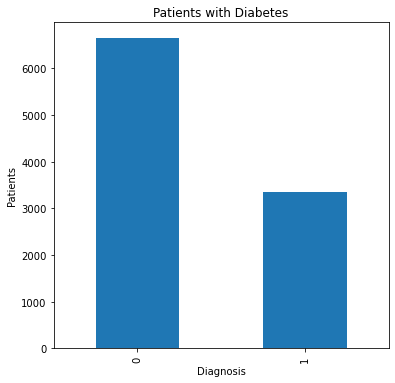

In [40]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
from azureml.widgets import RunDetails
%matplotlib inline 


# ワークスペース内にAzureMLの実験を作成する★
experiment = Experiment(workspace=ws, name="mslearn-diabetes")

# 実験データのロギングを開始し、実験実行のリファレンスを取得★
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# RunDetailsウィジェットで詳細表示
RunDetails(run).show()

# ローカルデータよりデータを読み込む
data = pd.read_csv('data/diabetes.csv')

# 行をカウントし、結果を記録
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# 糖尿病患者と非糖尿病患者の数をプロットしてロギング
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()

# イメージをロギング★
run.log_image(name='label distribution', plot=fig)

# 別々に妊娠数を記録する
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

# 数値列の要約統計を記録
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat=keys[index], value = values[index])
        
# データのサンプルを保存し、実験の出力にアップロード
data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

# 実験の終了
run.complete()

## エクスペリメントの詳細取得

- `Run`についての詳細URL : https://docs.microsoft.com/ja-jp/python/api/azureml-core/azureml.core.run(class)?view=azure-ml-py
- `Run.get_metrics()`でロギングされたメトリックを取得できる
- `Run.get_file_names`でアップロードしたファイル名を取得できる
- `Run.download_files(prefix, output_directory)`でダウンロード可能
- トラブルシューティング時は以下も利用すると良い
    - `Run.get_details`で基本的な詳細情報
    - `Run.get_details_with_log`で詳細情報と実行中に生成されたログファイル

In [49]:
import json

# ロギングされたメトリックの取得
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

# 出力ファイルの取得
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)

# 実行に関する基本的な詳細情報
print("\nget_details:")
details = run.get_details()
for key, value in details.items():
    print('key: ', key, 'value: ', value)

# 実行の詳細情報と実行中に生成されたログファイルの内容
print("\nget_details_with_logs:")
details = run.get_details_with_logs()
for key, value in details.items():
    print('key: ', key, 'value: ', value)

Metrics:
observations : 10000
label distribution : aml://artifactId/ExperimentRun/dcid.51c56eff-c3c1-4e90-ac1e-f799183309d6/label distribution_1623907044.png
pregnancy categories : [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
PlasmaGlucose : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
DiastolicBloodPressure : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
TricepsThickness : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
SerumInsulin : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465278, 14.0, 39.0, 85.0, 197.0, 796.0]}
BMI : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [1000

## エクスペリメントスクリプトの実行

- エクスペリメント用のスクリプトを作成して、それに基づいてエクスペリメントを実行することもできる。
- スクリプト側に`Run.get_context()`メソッドを入れることで、エクスペリメントの実行コンテキストを取得できる
    - それ以外(`Run.log()`や`Run.complete()`)は同じ
- エクスペリメントスクリプトを実行する時は、`ScriptRunConfig`でコードやディレクトリ、環境を指定して`Run.submit`で実行する
    - 環境について
        - 構築は`Environment('環境名')`
        - パッケージの追加は`CondaDependencies.create()`で`packages`を作成し、`Environment.python.conda_dependencies`で指定
- `Run.wait_for_completion()`を書いておくことでエクスペリメントスクリプトの実行完了まで待てる

In [52]:
# フォルダの作成

import os, shutil

# 実験ファイル用のフォルダ作成
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# データファイルを実験フォルダにコピーする
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

In [53]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# 実験実行コンテキストの取得
run = Run.get_context()

# 糖尿病データセットの読み込み
data = pd.read_csv('diabetes.csv')

# 行を数え、結果を記録
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# ラベルの数を数えて記録
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# データのサンプルをoutputフォルダに保存(自動的にアップロードされる
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# 実行の終了
run.complete()

Overwriting diabetes-experiment-files/diabetes_experiment.py


In [54]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

# 実験用のPython環境の構築
env = Environment("experiment_env")

# 必要なパッケージがインストールされていることを確認する
# ※pipとAzure MLのデフォルトが必要
packages = CondaDependencies.create(conda_packages=['pip'],
                                    pip_packages=['azureml-defaults'])
env.python.conda_dependencies = packages

# スクリプトコンフィグの作成
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script='diabetes_experiment.py',
                                environment=env) 

# 実験の実行
experiment = Experiment(workspace=ws, name='mslearn-diabetes')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes_1623909749_f6aecf30',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-06-17T06:02:31.689166Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '715b882d-6e22-4778-917c-48422291ca6f',
  'azureml.git.repository_uri': 'https://github.com/iguru0331/mslearn-dp100.git',
  'mlflow.source.git.repoURL': 'https://github.com/iguru0331/mslearn-dp100.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': 'bc299ed21f5e071788f4f49f0dd752f22c4005db',
  'mlflow.source.git.commit': 'bc299ed21f5e071788f4f49f0dd752f22c4005db',
  'azureml.git.dirty': 'False'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
 

## エクスペリメントの実行履歴の表示

- `ws.experiments`で各エクスペリメントを調べることができる
    - さらに、指定したエクスペリメントにおいて`get_runs`メソッドを実行すると、各実行IDについて取得できる
        - 各実行IDに対して`get_metrics`メソッドを実行することで、メトリックを取得できる

In [67]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['mslearn-diabetes']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: mslearn-diabetes_1623909749_f6aecf30
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: 51c56eff-c3c1-4e90-ac1e-f799183309d6
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.51c56eff-c3c1-4e90-ac1e-f799183309d6/label distribution_1623907044.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.7779193

## MLflow

- **MLflow** : エクスペリメントの調整やメトリックの追跡のために、Databricks環境で使用される
    - MLflowのトラッキングURIを指定することでエクスペリメント実行時のデータを記録できる
        - `mlflow.set_tracking_uri(mlflow.get_tracking_uri)`でURI指定
    - `with mlflow.start_run()`内にトラッキングしたいコードを入れ、`mlflow.log_metric('メトリック名',メトリック)`で記録
    - `experiment.get_portal_url()`でポータル上のURLを取得できる
- エクスペリメントスクリプトでもできるが、スクリプト内に`azureml-mlflow`を入れることを忘れないこと